   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Outcome
0    500
1  

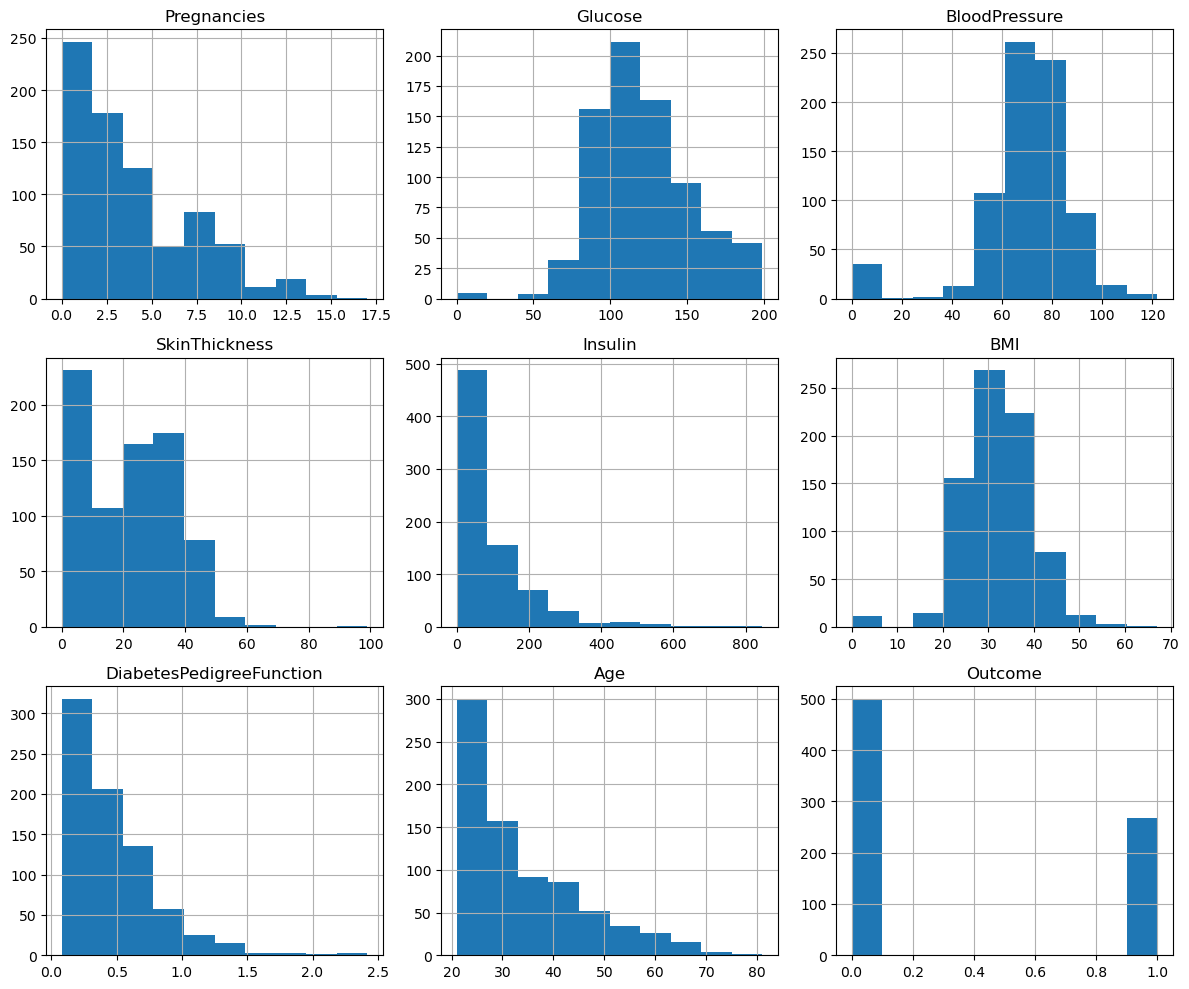

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 加载数据
data = pd.read_csv('diabetes.csv')
print(data.head())  # 查看前5行
print(data.isnull().sum())  # 检查缺失值
print(data['Outcome'].value_counts())  # 查看类别分布 0未患病 1患病

# 可视化特征分布
data.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

In [98]:
#无缺失值，但部分特征（如Insulin、SkinThickness）有大量0值（需处理）
#类别不平衡（健康样本更多），可能需后续处理（如过采样）
#数据预处理 处理0 医学用中位数
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler#标准化适合线性回归/逻辑回归 
#新学习用for in 来进行全部的填充
cols_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_to_fix:
    data[col] = data[col].replace(0, data[col].median())

In [99]:
#因为没有训练集以及测试集，所以我们要划分特征与标签
# 划分特征与标签
X = data.drop('Outcome', axis=1)#除了’outcome‘外所有
y = data['Outcome']
# 标准化 目的：将特征数据缩放至均值为0，标准差为1的标准正态分布
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)#fit_transform()先计算均值和标准差（fit），然后应用转换（transform）

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [100]:
#线性回归 分析特征与血糖关系
from sklearn.linear_model import LinearRegression
# 以Glucose葡萄糖为目标，其他特征为自变量
target = data['Glucose']
features = data.drop(['Glucose', 'Outcome'], axis=1)

lr = LinearRegression()
lr.fit(features, target)

# 输出系数 这样得出其他列跟Glucose的相关系数关系
#features.columns 获取全部特征值
#回归系数（lr.coef_）直接表示其他特征每增加1单位时，葡萄糖浓度的变化量
coefficients = pd.DataFrame({'Feature': features.columns, 'Coefficient': lr.coef_})

#按回归系数（Coefficient）降序排列
print(coefficients.sort_values('Coefficient', ascending=False))

                    Feature  Coefficient
5  DiabetesPedigreeFunction     4.835192
6                       Age     0.598408
4                       BMI     0.571345
1             BloodPressure     0.303424
3                   Insulin     0.096424
0               Pregnancies    -0.042206
2             SkinThickness    -0.052388


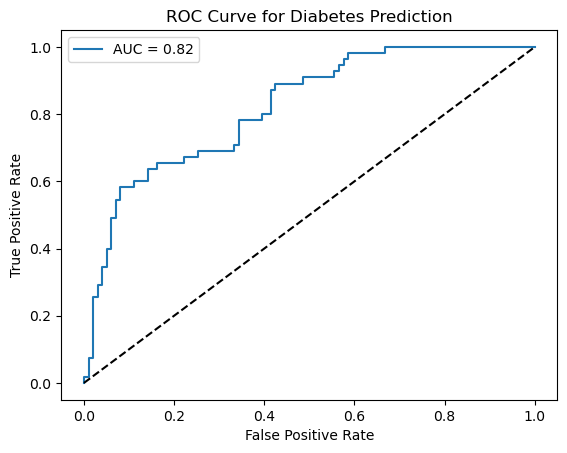

              precision    recall  f1-score   support

           0       0.80      0.69      0.74        99
           1       0.55      0.69      0.61        55

    accuracy                           0.69       154
   macro avg       0.68      0.69      0.68       154
weighted avg       0.71      0.69      0.69       154



In [101]:
#逻辑回归 糖尿病预测   ！解决二分类问题！
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc

# 训练模型
#logreg = LogisticRegression()
logreg = LogisticRegression(class_weight='balanced')  # 自动调整类别权重
logreg.fit(X_train, y_train) #X_train: 特征, y_train: 标签（0=健康, 1=糖尿病）

# 预测概率（用于ROC曲线）
y_pred_prob = logreg.predict_proba(X_test)[:, 1] # 取正类（糖尿病）的概率
#predict_proba() 返回每个样本属于两类（0和1）的概率，[:, 1] 表示只取患病的概率

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
#ROC曲线：横轴是假正率（FPR），纵轴是真正率（TPR），反映模型在不同阈值下的分类性能
#AUC（曲线下面积）：值越接近1，模型区分能力越强（图中AUC=0.82，表现良好）

# 绘制ROC曲线
#输出精确率（Precision）、召回率（Recall）、F1分数等详细指标
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Diabetes Prediction')
plt.legend()
plt.show()

# 输出分类报告
print(classification_report(y_test, logreg.predict(X_test)))

In [107]:
# 逻辑回归系数分析
#提取逻辑回归系数并构建DataFrame
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': logreg.coef_[0]})
#coef_ 是一个二维数组 [0]表示取第一行 对应二分类问题中的正类系数

#计算系数的绝对值
coefficients['Absolute_Coeff'] = np.abs(coefficients['Coefficient'])

#按绝对值降序排序
print(coefficients.sort_values('Absolute_Coeff', ascending=False))

                    Feature  Coefficient  Absolute_Coeff
1                   Glucose     1.184638        1.184638
5                       BMI     0.744290        0.744290
7                       Age     0.440886        0.440886
6  DiabetesPedigreeFunction     0.250209        0.250209
0               Pregnancies     0.238213        0.238213
4                   Insulin    -0.225265        0.225265
2             BloodPressure    -0.180644        0.180644
3             SkinThickness     0.039616        0.039616


In [109]:
#进行随机森林测试
# 沿用之前处理好的数据（X_scaled, y）
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# 初始化模型（默认参数）
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# 预测
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:, 1]  # 预测概率（用于AUC）

# 评估
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_pred_prob):.2f}")

              precision    recall  f1-score   support

           0       0.82      0.81      0.81        99
           1       0.66      0.67      0.67        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154

AUC Score: 0.84


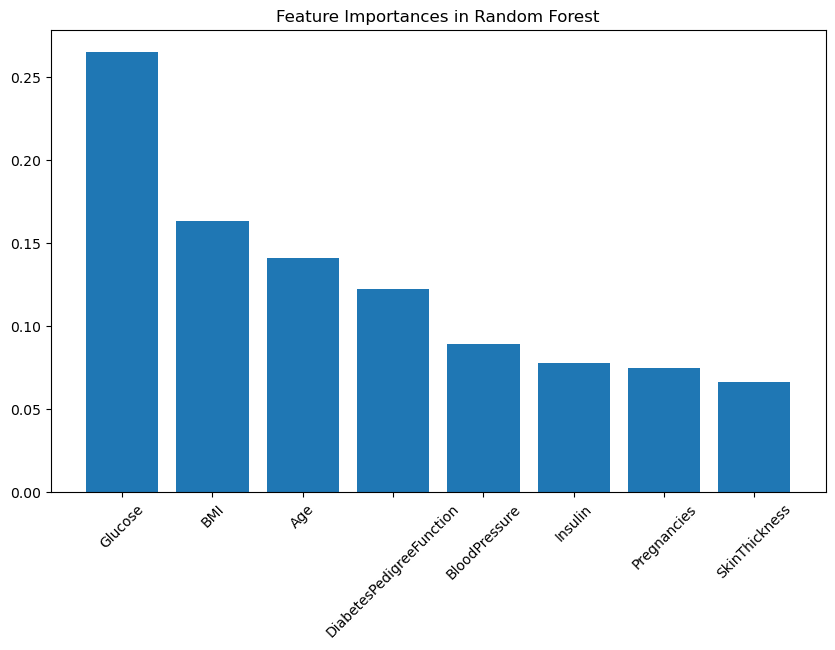

In [111]:
# 获取特征重要性
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # 降序排序

# 可视化
plt.figure(figsize=(10, 6))
plt.title("Feature Importances in Random Forest")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=45)
plt.show()

In [139]:
#超参数调优 网格搜索
from sklearn.model_selection import GridSearchCV
# 初始化模型（设置随机种子保证可复现性）
rf = RandomForestClassifier(
     max_depth=10,
    random_state=42,  # 固定随机种子
    n_jobs=-1,       # 使用所有CPU核心加速
    max_features='sqrt'  # 默认特征选择方式
)

# 定义参数网格
param_grid = {
    'n_estimators': [50, 100, 200],# 树数量（平衡性能与计算成本）
    'max_depth': [None, 10, 20],# 控制过拟合
    'min_samples_split': [2, 5, 10],# 节点最小分裂样本数
    'min_samples_leaf': [1, 2, 4], # 叶节点最小样本数
    'criterion': ['gini', 'entropy']# 分裂标准
}

# 网格搜索
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,# 5折交叉验证更稳健
                           scoring='roc_auc', # 使用AUC作为评估指标
                           n_jobs=-1,)#AUC面积 对二分类
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# 评估优化后模型
print(f"Optimized AUC: {roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]):.2f}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Optimized AUC: 0.84


In [141]:
#创建一个对象
rf2 = RandomForestClassifier(criterion='entropy',
                             max_depth=10,
                            min_samples_leaf=5,
                            min_samples_split=12,
                            n_estimators=50,
                            n_jobs=-1,
                            random_state=1)

In [143]:
#先训练一下
rf2.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       min_samples_split=12, n_estimators=50, n_jobs=-1,
                       random_state=1)

In [145]:
print(data['BloodPressure'].describe())

count    768.000000
mean      72.386719
std       12.096642
min       24.000000
25%       64.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: BloodPressure, dtype: float64


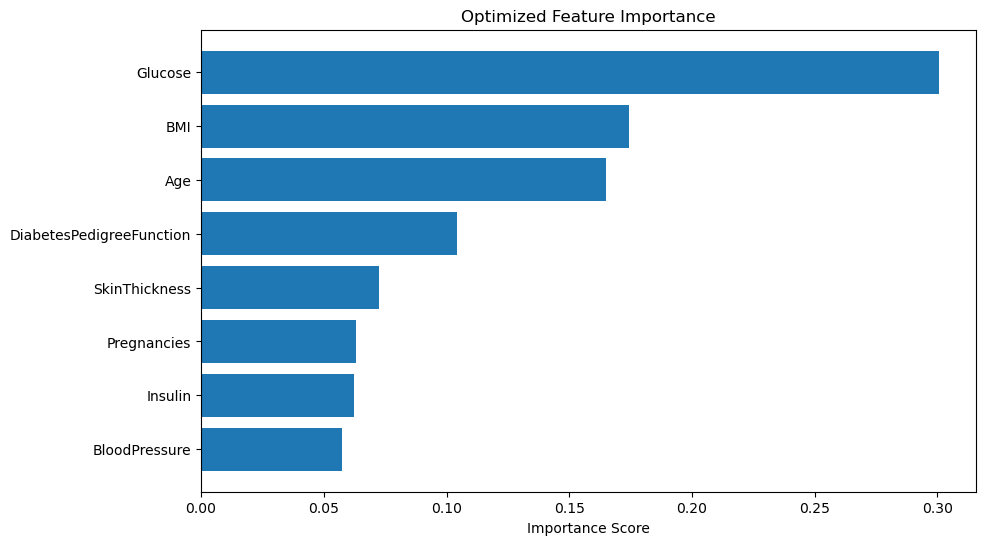

In [154]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf2.feature_importances_
}).sort_values('Importance', ascending=False)
# 可视化
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(importance['Feature'], importance['Importance'])
plt.xlabel('Importance Score')
plt.title('Optimized Feature Importance')
plt.gca().invert_yaxis()
plt.show()